In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import json
import ast
from transformers import AutoTokenizer, AutoModel, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import mean_squared_error

In [2]:
# Set device for computation
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Load ratings data
ratings = pd.read_csv('/kaggle/input/the-movie-dataset/new_ratings_small.csv')
movie_ids = np.unique(ratings['movieId'].astype(int))

In [5]:
# Function to reindex movie IDs
def reindex(movie_id): 
    return np.where(movie_ids == movie_id)[0][0]

In [6]:
# Function to load and process data
def load_data(path):
    train_df = pd.read_csv(path + 'train_data.csv')
    test_df = pd.read_csv(path + 'test_data.csv')
    eval_df = pd.read_csv(path + 'val_data.csv')
    community_df = pd.concat([train_df, eval_df], ignore_index=True)

    n_users = np.unique(np.concatenate([train_df['userId'], test_df['userId'], eval_df['userId']])).size
    n_items = np.unique(np.concatenate([train_df['movieId'], test_df['movieId'], eval_df['movieId']])).size

    community_data = np.zeros((n_users, n_items), dtype='float32')
    test_data = np.zeros((n_users, n_items), dtype='float32')

    # Fill community and test matrices
    for _, row in community_df.iterrows():
        user_idx = int(row['userId']) - 1
        movie_idx = reindex(row['movieId'])
        community_data[user_idx, movie_idx] = row['rating']

    for _, row in test_df.iterrows():
        user_idx = int(row['userId']) - 1
        movie_idx = reindex(row['movieId'])
        test_data[user_idx, movie_idx] = row['rating']

    print(f'Number of users: {n_users}')
    print(f'Number of items: {n_items}')
    return community_df, community_data, test_data, n_users, n_items

In [8]:
# Load data
community_df, community_data, test_data, n_users, n_items = load_data('/kaggle/input/the-movie-dataset/')

Number of users: 671
Number of items: 9025


In [9]:
# Configuration settings
config = {
    'checkpoint': 'distilbert-base-cased', 
    'n_clusters': n_users,
    'truncation': True,
    'max_length': 512
}

In [10]:
# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(config['checkpoint'])
model = AutoModel.from_pretrained(config['checkpoint']).to(device)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [11]:
link_tmdb = pd.read_csv('/kaggle/input/the-movies-dataset/links.csv')
movie_metadatas = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')

/tmp/ipykernel_30/4148980327.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadatas = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')


In [12]:
def combine_features(movie_id: int, link_tmdb, movie_metadatas, credits):
    
    # Mapping movie id with tmdbId
    tmdb_id = int(link_tmdb[link_tmdb.movieId == movie_id].tmdbId.values[0])
    
    # Getting movie metadata by tmdb id (convert tmdb_id to str because movie_metadata.id is str)
    movie_metadata = movie_metadatas[movie_metadatas.id == str(tmdb_id)]
    credit = credits[credits.id == tmdb_id]

    # Get budget
    budget = movie_metadata.budget.values[0]
    if budget == str(0) or budget is None:
        budget = "Not available"
    else:
        budget = f"${budget}"

    # Get genres
    genres = ""
    genres_str = movie_metadata.genres.values[0]
    genres_list = ast.literal_eval(genres_str)
    if len(genres_list) != 0:
        genres = ', '.join([genre['name'] for genre in genres_list])

    # Get production companies
    production_company = ""
    pdt_company_str = movie_metadata.production_companies.values[0]
    pdt_company_list = ast.literal_eval(pdt_company_str)
    if len(pdt_company_list) != 0:
        production_company = ', '.join([prt_company['name'] for prt_company in pdt_company_list])

    # Get production countries
    production_countries = ""
    pdt_countries_str = movie_metadata.production_countries.values[0]
    pdt_countries_list = ast.literal_eval(pdt_countries_str)
    if len(pdt_countries_list) != 0:
        production_countries = ', '.join([prt_countries['name'] for prt_countries in pdt_countries_list])

    # Get runtime
    runtime = movie_metadata.runtime.values[0]
    if runtime:
        runtime = f"{int(runtime)}"  # Loại bỏ phần thập phân nếu có

    # Get casts
    casts = ""
    cast_str = credit.cast.values[0]
    cast_list = ast.literal_eval(cast_str)
    if len(cast_list) != 0:
        casts = ', '.join([cast['name'] for cast in cast_list])

    # Get overview
    overview = movie_metadata.overview.values[0]

    # Combine all features into one text with proper formatting
    combined_features = (
        f"Overview: {overview} "
        f"Genres: {genres}. "
        f"Casts: {casts}. "
        f"Budget: {budget}. "      
        f"Production Company: {production_company}. "
        f"Production Countries: {production_countries}. "
        f"Runtime: {runtime} minutes."
    )

    return combined_features

In [13]:
combine_features(3, link_tmdb, movie_metadatas, credits)

"Overview: A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max. Genres: Romance, Comedy. Casts: Walter Matthau, Jack Lemmon, Ann-Margret, Sophia Loren, Daryl Hannah, Burgess Meredith, Kevin Pollak. Budget: Not available. Production Company: Warner Bros., Lancaster Gate. Production Countries: United States of America. Runtime: 101 minutes."

In [14]:
# Function to extract item embeddings
def get_item_embeddings(features, batch_size=64):
    embeddings = []
    for i in range(0, len(features), batch_size):
        batch = features[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length']).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            # Use average pooling to get embeddings
            embeddings.extend(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
    return embeddings

In [15]:
# Fetch combined features and compute item embeddings
combined_features = [combine_features(mid, link_tmdb, movie_metadatas, credits) for mid in movie_ids]
item_embeddings = get_item_embeddings(combined_features)

In [16]:
# Calculate cosine similarity matrix for items
cosine_sim = linear_kernel(item_embeddings, item_embeddings)

In [17]:
# Function to calculate average rating per item
def calculate_average_ratings(data):
    return [sum(data[:, i]) / (np.count_nonzero(data[:, i]) + 0.1) for i in range(data.shape[1])]

In [18]:
# Calculate average ratings for the community
average_ratings_community = calculate_average_ratings(community_data)

In [19]:
# Identify items with zero ratings
index_zero_rating = np.where(np.array(average_ratings_community) == 0.0)[0]

In [20]:
index_zero_rating

array([ 104, 1409, 1738, 1943, 3056, 3759, 4352, 4366, 4467, 4571, 5076,
       5249, 5318, 5465, 5573, 5815, 5844, 5872, 5883, 6073, 6176, 6316,
       6348, 6503, 6510, 6521, 6625, 6719, 6764, 6799, 6851, 6927, 7093,
       7185, 7317, 7508, 8354, 8558, 8706, 8730, 8805, 8863])

In [21]:
# Function to find top similar items
def get_top_similar_items(item_id, top_k, average_ratings):
    sim_scores = list(enumerate(cosine_sim[item_id]))
    sorted_similar_items = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    similar_items = [item[0] for item in sorted_similar_items[1:top_k]]

    real_scores = [(i, average_ratings[i]) for i in similar_items]
    sorted_scores = sorted(real_scores, key=lambda x: x[1], reverse=True)
    return [item[0] for item in sorted_scores[:int(top_k / 2)]]

In [22]:
# Function to update ratings for items with zero ratings
def update_ratings(average_ratings, zero_indices, top_k):
    updated_ratings = average_ratings.copy()
    for idx in zero_indices:
        top_similar = get_top_similar_items(idx, top_k, average_ratings)
        avg_rating = sum([average_ratings[i] for i in top_similar]) / (len(top_similar) + 1e-5)
        updated_ratings[idx] = avg_rating
    return updated_ratings

In [23]:
# Update community ratings
updated_ratings_community = update_ratings(average_ratings_community, index_zero_rating, top_k=10)

In [24]:
np.where(np.array(updated_ratings_community) == 0.0)[0]

array([], dtype=int64)

In [25]:
# Function to calculate user embeddings based on ratings and item embeddings
def calculate_user_embeddings(ratings_df, item_embeddings):
    user_embeddings = []
    grouped = ratings_df.groupby('userId')
    item_embeddings = np.array(item_embeddings)  

    for user_id, user_data in grouped:
        movie_indices = [reindex(movie_id) for movie_id in user_data['movieId'].values]
        user_item_embeddings = item_embeddings[movie_indices]

        weighted_sum = np.dot(user_data['rating'].values, user_item_embeddings)
        user_embedding = weighted_sum / user_data['rating'].sum()
        user_embeddings.append(user_embedding)

    return np.array(user_embeddings)

In [26]:
# Calculate user embeddings
user_embeddings = calculate_user_embeddings(community_df, item_embeddings)

In [27]:
user_embeddings.shape

(671, 768)

In [28]:
# Perform KMeans clustering on user embeddings
n_clusters = config['n_clusters']
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(user_embeddings)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


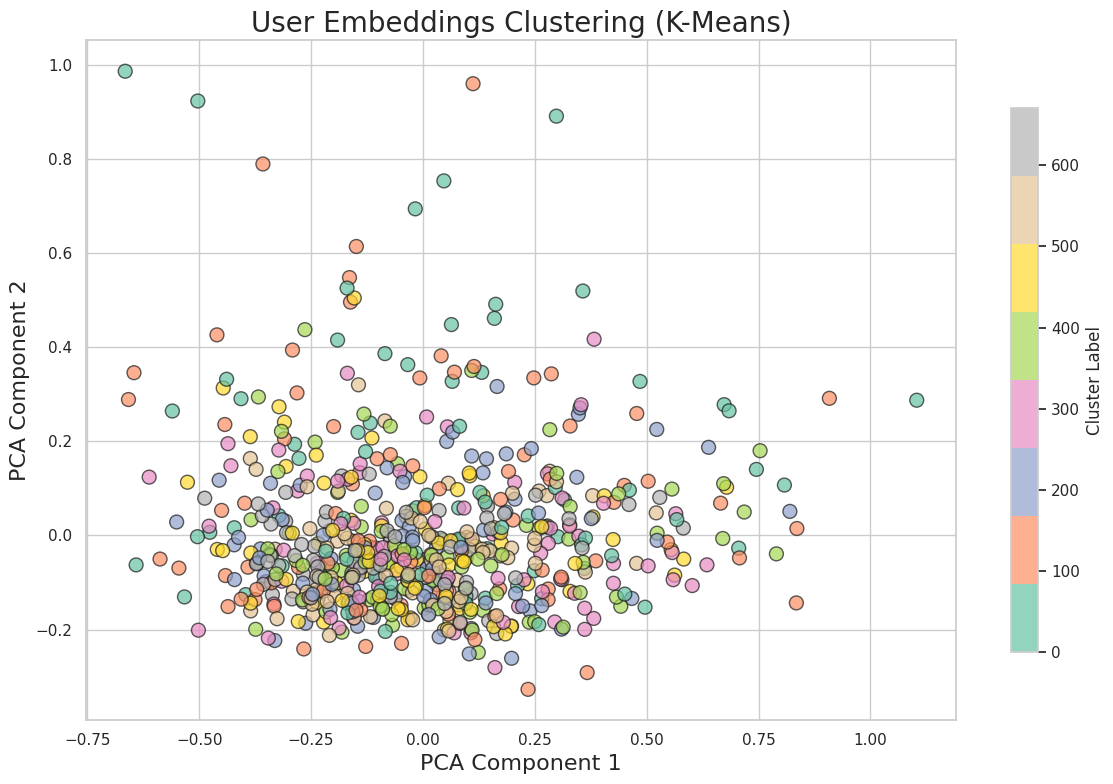

In [29]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_user_embeddings = pca.fit_transform(user_embeddings)

# Visualize user clusters
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
scatter = plt.scatter(reduced_user_embeddings[:, 0], reduced_user_embeddings[:, 1], 
                      c=cluster_labels, cmap='Set2', marker='o', alpha=0.7, edgecolor='k', s=100)
plt.title('User Embeddings Clustering (K-Means)', fontsize=20)
plt.xlabel('PCA Component 1', fontsize=16)
plt.ylabel('PCA Component 2', fontsize=16)
plt.colorbar(scatter, label="Cluster Label", shrink=0.8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Function to preprocess dataset for training
def preprocess_function(examples):
    inputs = tokenizer(examples['text'], padding="max_length", truncation=config['truncation'], max_length=config['max_length'], return_tensors="pt")
    return {key: val.to(device) for key, val in inputs.items()}

In [31]:
# Function to create dataset for training
def create_dataset(features, labels, is_train):
    # Ensure features and labels are properly aligned
    if is_train:
        if len(features) != len(labels):
            raise ValueError(f"Mismatch: Features length {len(features)} does not match Labels length {len(labels)}")

        data_dict = {
            "text": features,
            "label": labels
        }
    else:
        data_dict = {
            "text": features,
        }
    
    # Create dataset from dictionary
    dataset = Dataset.from_dict(data_dict)
    dataset = dataset.map(preprocess_function, batched=True)

    return dataset


In [32]:
# Create training and testing datasets
community_dataset = create_dataset(combined_features, updated_ratings_community, is_train=True)
train_test_split = community_dataset.train_test_split(test_size=0.1)
community_train = train_test_split['train']
community_test = train_test_split['test']

Map:   0%|          | 0/9025 [00:00<?, ? examples/s]

In [33]:
community_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8122
})

## Community Model Fine-tuning

In [34]:
# Initialize and train the model using Trainer
model = DistilBertForSequenceClassification.from_pretrained(config['checkpoint'], num_labels=1).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=9,
    per_device_train_batch_size=32,
    weight_decay=0.01,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=community_train,
    eval_dataset=community_test,
    tokenizer=tokenizer,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [37]:
# Fine-tune the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.606317
2,0.901900,0.594265
3,0.901900,0.633218
4,0.542400,0.676524
5,0.542400,0.761770
6,0.354700,0.758176
7,0.354700,0.785642
8,0.240600,0.781423
9,0.240600,0.805797


TrainOutput(global_step=2286, training_loss=0.4714853582106863, metrics={'train_runtime': 2074.976, 'train_samples_per_second': 35.228, 'train_steps_per_second': 1.102, 'total_flos': 9682929222580224.0, 'train_loss': 0.4714853582106863, 'epoch': 9.0})

In [38]:
# Save model and tokenizer after training
trainer.save_model("./best_model")  # Saves the model weights, configuration, and training arguments
tokenizer.save_pretrained("./best_model")  # Saves the tokenizer

('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')

### Personality Model Fine-Tuning

In [39]:
def get_personality_dataset(cluster_labels, cluster_idx, community_data, link_tmdb, movie_metadatas, credits):
    # Find users that belong to the current cluster
    users = np.where(cluster_labels == cluster_idx)[0]
    
    # Extract ratings for these users
    personality_ratings = community_data[users]
    
    # Find the non-zero indices in the matrix
    row_indices, col_indices = np.nonzero(personality_ratings)  # Returns row, col indices where values are non-zero
    
    # Map the column (movie) indices to the movie IDs and extract features
    personality_features = [combined_features[col] for col in col_indices]
    
    # Extract the non-zero labels (ratings)
    personality_labels = personality_ratings[row_indices, col_indices]
    
    # Create the dataset
    return create_dataset(personality_features, personality_labels, is_train=True)


In [40]:
def predict_ratings(cluster_labels, cluster_idx, model, test_data, link_tmdb, movie_metadatas, credits):
    users = np.where(cluster_labels == cluster_idx)[0]
    ratings = test_data[users]
    
    # Find the non-zero indices and corresponding movie features
    row_indices, col_indices = np.nonzero(ratings)
    features = [combined_features[col] for col in col_indices]
    
    # Create the dataset for these features (assuming you already have a function for this)
    encoded_items = create_dataset(features, labels=None, is_train=False)
    encoded_items.set_format(type="torch", columns=['input_ids', 'attention_mask'])

    predictions = []
    dataloader = DataLoader(encoded_items, batch_size=128)
    
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for batch in dataloader:
            # Get the model outputs
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            logits = outputs.logits.cpu().numpy()  # Move logits back to CPU
            predictions.extend(logits.flatten())  # Collect predictions

    return predictions

In [41]:
# Evaluate the model by calculating MSE and RMSE
def evaluate_model(test_data, predicted_ratings, cluster_labels):
    test_ratings = get_test_ratings(test_data, cluster_labels)
    mse = mean_squared_error(test_ratings, predicted_ratings)
    rmse = np.sqrt(mse)
    print(f'MSE: {mse}, RMSE: {rmse}')

In [42]:
# Get the test ratings
def get_test_ratings(test_data, cluster_labels):
    ratings = []
    for i in np.unique(cluster_labels):
        idx = np.where(cluster_labels == i)[0]
        data_cluster = test_data[idx]             
        row, col = np.nonzero(data_cluster)  
        ratings.extend(data_cluster[row, col])       
    return ratings

### Load Community Model

In [43]:
community_model_path = "./best_model"
original_community_model = DistilBertForSequenceClassification.from_pretrained(
    community_model_path, num_labels=1).to(device)

In [44]:
personality_training_args = TrainingArguments(
    output_dir='./personality_results',                 
    num_train_epochs=9,                      
    per_device_train_batch_size=32,          
    weight_decay=0.01,                      
    learning_rate=2e-5,                    
    fp16=True,                                
    eval_strategy="no",                
    save_strategy="no",                   
)

In [45]:
from tqdm.auto import tqdm

# Main training loop for each user cluster
all_predictions = []

for cluster_idx in tqdm(np.unique(cluster_labels)):
    # Prepare the dataset for the current user cluster
    personality_dataset = get_personality_dataset(
        cluster_labels, cluster_idx, community_data, link_tmdb, movie_metadatas, credits
    )
    
    # Reset the model to its initial weights before training on new data
    personality_model = copy.deepcopy(original_community_model)
    personality_model.to(device)
    
    # Initialize the Trainer for the current personality model and dataset
    trainer = Trainer(
        model=personality_model,
        args=personality_training_args,
        train_dataset=personality_dataset,
        tokenizer=tokenizer,
    )
    
    # Train the personality model
    trainer.train()

    # Predict ratings for the current cluster using the fine-tuned personality model
    cluster_predictions = predict_ratings(
        cluster_labels, cluster_idx, personality_model, test_data, link_tmdb, movie_metadatas, credits
    )
    
    # Append predictions to the list
    all_predictions.extend(cluster_predictions)

  0%|          | 0/671 [00:00<?, ?it/s]

Map:   0%|          | 0/89 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/123 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1335 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/721 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/87 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/294 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/621 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/394 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/273 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/65 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/194 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/251 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/191 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1861 [00:00<?, ? examples/s]

Step,Training Loss
500,0.744800


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/787 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/216 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/702 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/89 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/421 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1597 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/512 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/294 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/705 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/823 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/429 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/209 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/675 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/323 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/506 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/647 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/251 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/321 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/65 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/93 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/87 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/497 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/145 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/307 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/89 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/147 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/902 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/306 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/194 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1728 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/666 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/432 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/274 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/186 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/123 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/358 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/318 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/172 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/597 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/478 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/123 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/171 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/673 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/215 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/205 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/542 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/482 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/520 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/394 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/65 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/335 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/258 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/318 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/302 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1692 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/145 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/942 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1005 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1052 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/868 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/209 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/2381 [00:00<?, ? examples/s]

Step,Training Loss
500,0.708400


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/274 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/515 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/123 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/370 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/298 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1013 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/121 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/318 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/418 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/407 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/918 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/690 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

Step,Training Loss


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [48]:
# Evaluate final model performance
evaluate_model(test_data, all_predictions, cluster_labels)

MSE: 0.8978787660598755, RMSE: 0.9475646615028381
